In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dataset shopee chottt.csv to dataset shopee chottt.csv


In [ ]:
pip install pandas scikit-learn joblib matplotlib seaborn


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Đọc file CSV (sửa lại tên file đúng với em)
df = pd.read_csv("dataset shopee chottt.csv", encoding="utf-8")

print("📌 Kích thước dữ liệu gốc:", df.shape)
print("📌 Tên các cột:", df.columns)
print(df.head())


📌 Kích thước dữ liệu gốc: (10000, 2)
📌 Tên các cột: Index(['review', 'sentiment'], dtype='object')
                                              review sentiment
0  phù hợp giá tiền, đóng gói đẹp, giao hàng nhan...  positive
1  đóng gói sản phẩm cẩn thận, giao hàng nhanh, s...  positive
2  dong gói sản phẩm đẹp và chắc chắn thời gian g...  positive
3                                        áo hơi mỏng  negative
4  đóng gói hàng đẹp, chắc chắn giao hàng nhanh á...  positive


In [ ]:
print("📊 Phân bố nhãn ban đầu:")
print(df['sentiment'].value_counts())


📊 Phân bố nhãn ban đầu:
sentiment
positive    7689
negative    1774
neutral      537
Name: count, dtype: int64


In [ ]:

# Hàm làm sạch văn bản
def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)   # bỏ link
    text = re.sub(r"[\r\n\t]", " ", text)           # bỏ xuống dòng, tab
    text = re.sub(r"[^0-9a-zA-ZÀ-ỹ\s]", " ", text) # bỏ ký tự đặc biệt
    text = re.sub(r"\s+", " ", text).strip()        # bỏ khoảng trắng thừa
    return text
# Áp dụng làm sạch
df["clean"] = df["review"].map(clean_text_basic)

# Bỏ các dòng bị trống sau khi xử lý
df = df[df["clean"].str.strip() != ""].reset_index(drop=True)

# Chuyển nhãn chữ -> số
label_map = {"positive": 1, "neutral": 0, "negative": -1}
df["label"] = df["sentiment"].map(label_map)

print("📌 Sau tiền xử lý còn:", df.shape[0], "dòng dữ liệu")
print(df[["review", "clean", "sentiment", "label"]].head())


📌 Sau tiền xử lý còn: 10000 dòng dữ liệu
                                              review  \
0  phù hợp giá tiền, đóng gói đẹp, giao hàng nhan...   
1  đóng gói sản phẩm cẩn thận, giao hàng nhanh, s...   
2  dong gói sản phẩm đẹp và chắc chắn thời gian g...   
3                                        áo hơi mỏng   
4  đóng gói hàng đẹp, chắc chắn giao hàng nhanh á...   

                                               clean sentiment  label  
0  phù hợp giá tiền đóng gói đẹp giao hàng nhanh ...  positive      1  
1  đóng gói sản phẩm cẩn thận giao hàng nhanh sản...  positive      1  
2  dong gói sản phẩm đẹp và chắc chắn thời gian g...  positive      1  
3                                        áo hơi mỏng  negative     -1  
4  đóng gói hàng đẹp chắc chắn giao hàng nhanh áo...  positive      1  


In [ ]:
# ============================
# 6. Chia train/test (90% train - 10% test)
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["clean"],
    df_balanced["label"],
    test_size=0.1,        # 🔹 chỉ còn 10% test
    random_state=42,
    stratify=df_balanced["label"]
)

print("\n📊 Train size:", len(X_train), "| Test size:", len(X_test))
print("🚦 Phân bố nhãn tập train:\n", y_train.value_counts())
print("\n🚦 Phân bố nhãn tập test:\n", y_test.value_counts())



📊 Train size: 13809 | Test size: 1535
🚦 Phân bố nhãn tập train:
 label
 1    6905
-1    5304
 0    1600
Name: count, dtype: int64

🚦 Phân bố nhãn tập test:
 label
 1    767
-1    590
 0    178
Name: count, dtype: int64


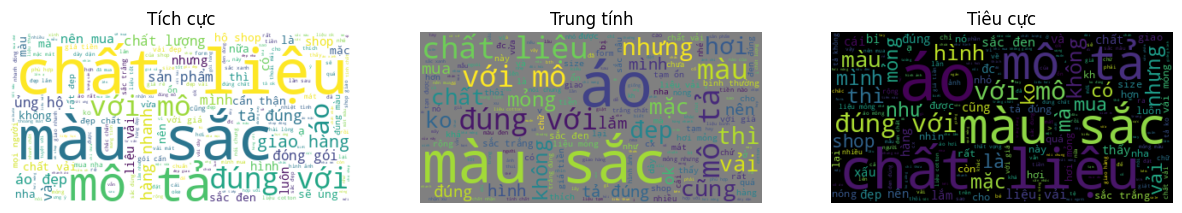

In [ ]:
from wordcloud import WordCloud
# Tách bình luận theo nhãn
positive_text = " ".join(df[df['sentiment']=='positive']['clean'])
negative_text = " ".join(df[df['sentiment']=='negative']['clean'])
neutral_text  = " ".join(df[df['sentiment']=='neutral']['clean'])  # thêm neutral

# Tạo WordCloud
wordcloud_pos = WordCloud(width=400, height=200, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=400, height=200, background_color='black').generate(negative_text)
wordcloud_neu = WordCloud(width=400, height=200, background_color='gray').generate(neutral_text)

# Vẽ
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off'); plt.title("Tích cực")
plt.subplot(1,3,2)
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis('off'); plt.title("Trung tính")
plt.subplot(1,3,3)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off'); plt.title("Tiêu cực")
plt.show()


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=8000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:

# ============================
# 10. Huấn luyện mô hình Naive Bayes
# ============================
model = MultinomialNB()
model.fit(X_train_vec, y_train)


MultinomialNB()

In [ ]:
y_pred = model.predict(X_test_vec)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification report:\n", classification_report(
    y_test, y_pred, target_names=["Negative","Neutral","Positive"]
))


🎯 Accuracy: 0.8827361563517915

📊 Classification report:
               precision    recall  f1-score   support

    Negative       0.83      0.96      0.89       590
     Neutral       0.95      0.43      0.59       178
    Positive       0.92      0.93      0.93       767

    accuracy                           0.88      1535
   macro avg       0.90      0.77      0.80      1535
weighted avg       0.89      0.88      0.87      1535



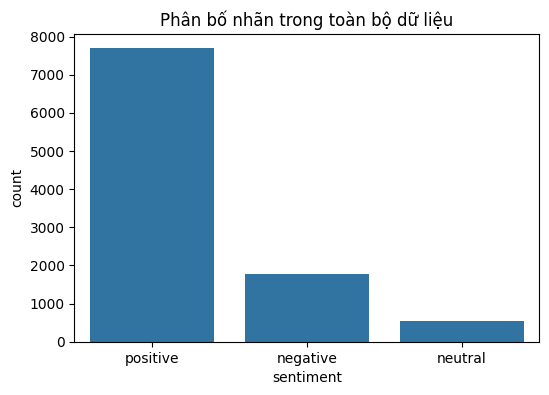

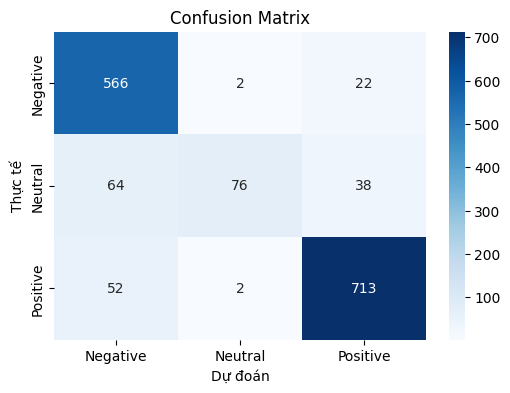

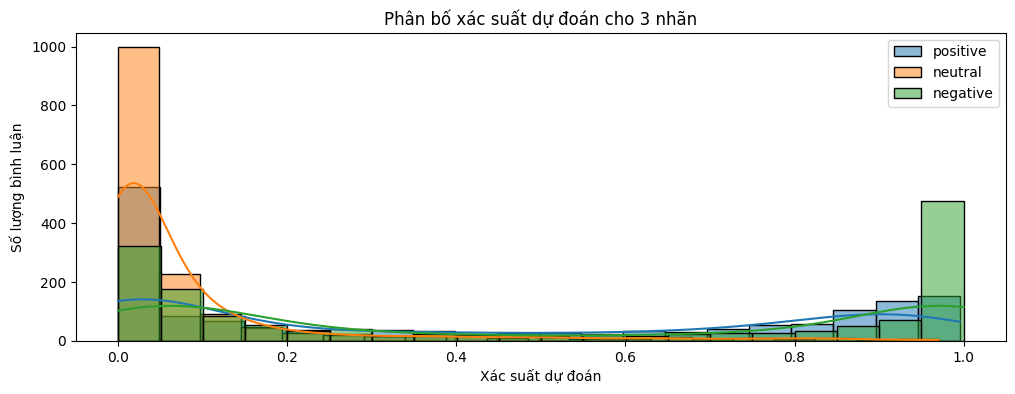

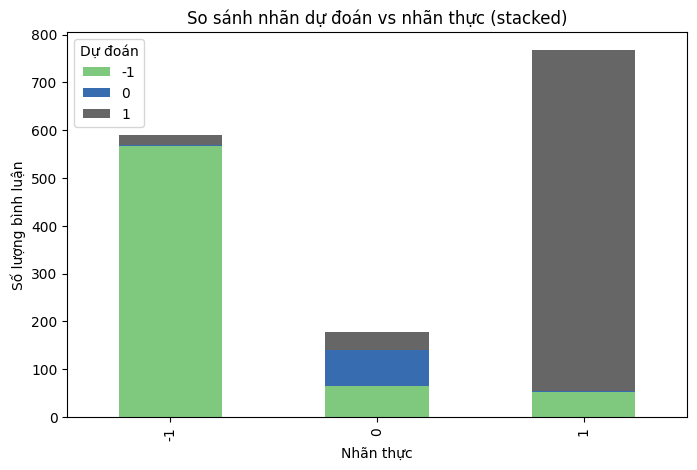

In [ ]:
# 1️⃣ Biểu đồ phân bố nhãn toàn bộ dataset
plt.figure(figsize=(6,4))
sns.countplot(x=df["sentiment"])
plt.title("Phân bố nhãn trong toàn bộ dữ liệu")
plt.show()

# 2️⃣ Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Neutral","Positive"],
            yticklabels=["Negative","Neutral","Positive"])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix")
plt.show()
#Phân bố xác suất dự đoán
# =============================
y_prob = model.predict_proba(X_test_vec)  # shape: (num_samples, 3)

plt.figure(figsize=(12,4))
for i, label in enumerate(['positive','neutral','negative']):
    sns.histplot(y_prob[:,i], bins=20, kde=True, label=label, alpha=0.5)
plt.title("Phân bố xác suất dự đoán cho 3 nhãn")
plt.xlabel("Xác suất dự đoán")
plt.ylabel("Số lượng bình luận")
plt.legend()
plt.show()
#Stacked bar chart dự đoán vs thực tế
# =============================
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
ct = pd.crosstab(df_eval['Actual'], df_eval['Predicted'])

ct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Accent')
plt.title("So sánh nhãn dự đoán vs nhãn thực (stacked)")
plt.xlabel("Nhãn thực")
plt.ylabel("Số lượng bình luận")
plt.legend(title="Dự đoán")
plt.show()

In [ ]:
import joblib
joblib.dump(model, 'nb_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

In [ ]:
def predict_comment(comment):
    text = clean_text_basic(comment)
    vec = vectorizer.transform([text])
    pred = model.predict(vec)[0]
    prob = model.predict_proba(vec).max()

    if pred == 1:
        label = "Tích cực"
    elif pred == 0:
        label = "Trung tính"
    else:
        label = "Tiêu cực"

    return label, round(prob, 3)

# Test nhanh
print(predict_comment("Sản phẩm rất đẹp, giao hàng nhanh"))
print(predict_comment("Áo xấu, vải tệ, không hài lòng"))
print(predict_comment("Cũng bình thường, không có gì đặc biệt"))


('Tích cực', np.float64(0.999))
('Tiêu cực', np.float64(0.974))
('Trung tính', np.float64(0.665))


In [ ]:
!pip install streamlit pyngrok


In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import re
import numpy as np
import matplotlib.pyplot as plt

# --- Load model & vectorizer ---
model = joblib.load("nb_model.joblib")
vectorizer = joblib.load("tfidf_vectorizer.joblib")

# --- Hàm làm sạch văn bản ---
def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)   # bỏ link
    text = re.sub(r"[\r\n\t]", " ", text)           # bỏ xuống dòng
    text = re.sub(r"[^0-9a-zA-ZÀ-ỹ\s]", " ", text)  # bỏ ký tự đặc biệt
    text = re.sub(r"\s+", " ", text).strip()
    return text

# --- Mapping nhãn ---
label_map = {
    -1: "Tiêu cực 😞",
     0: "Trung tính 😐",
     1: "Tích cực 😀"
}

# --- Hàm dự đoán ---
def predict_comment(comment):
    text = clean_text_basic(comment)
    vec = vectorizer.transform([text])
    pred = model.predict(vec)[0]
    probas = model.predict_proba(vec)[0]
    max_prob = np.max(probas)
    return label_map[pred], max_prob, probas

# --- Giao diện Streamlit ---
st.title("💬 Dự đoán cảm xúc bình luận sản phẩm thời trang Shopee")
# Layout 2 cột
col1, col2 = st.columns([2, 1])

with col1:
    comment = st.text_area("✍️ Nhập bình luận của bạn:")

    if st.button("🚀 Dự đoán"):
        if comment.strip() != "":
            label, prob, probas = predict_comment(comment)
            st.subheader("👉 Kết quả:")
            st.success(f"{label} (Độ tin cậy: {prob:.2f})")
            # Hiển thị text xác suất
            st.markdown("### 📌 Xác suất từng nhãn:")
            st.write(f"- Tiêu cực 😞: {probas[0]:.2f}")
            st.write(f"- Trung tính 😐: {probas[1]:.2f}")
            st.write(f"- Tích cực 😀: {probas[2]:.2f}")

            # Vẽ biểu đồ bên cột phải
            with col2:
                labels = [" 😞", " 😐", " 😀"]
                colors = ["#FF6B6B", "#FFD93D", "#6BCB77"]  # đỏ, vàng, xanh lá

                fig, ax = plt.subplots(figsize=(4,5))
                ax.bar(labels, probas, color=colors)
                ax.set_ylim(0,1)
                ax.set_ylabel("Xác suất")
                ax.set_title("Biểu đồ xác suất")

                # Thêm số trên cột
                for i, v in enumerate(probas):
                    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

                st.pyplot(fig)
        else:
            st.warning("⚠️ Vui lòng nhập bình luận trước khi dự đoán!")


Overwriting app.py


In [ ]:
!pip install streamlit pyngrok --upgrade -q


In [ ]:
!rm -rf /root/.config/ngrok


In [ ]:
!ngrok config add-authtoken "316jh3VhXFVW4r8v4D7lt2oi9Xy_7ZKqka6v9XmXV5Mmn8DFJ"


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# 1️⃣ Dừng tunnel cũ nếu có
ngrok.kill()

# 2️⃣ Thêm authtoken (chỉ cần chạy mỗi session mới)
!ngrok config add-authtoken "316jh3VhXFVW4r8v4D7lt2oi9Xy_7ZKqka6v9XmXV5Mmn8DFJ"

# 3️⃣ Mở tunnel mới
public_url = ngrok.connect(addr="8501")
print("🌍 URL truy cập app:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌍 URL truy cập app: NgrokTunnel: "https://575b3ff14e75.ngrok-free.app" -> "http://localhost:8501"


In [410]:
from google.colab import drive
drive.mount('/content/drive')

# copy file notebook vào Drive
!cp /content/NLPPPPP.ipynb /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/NLPPPPP.ipynb': No such file or directory
